In [1]:
import json
import os
import cv2
import numpy as np
import random

from custom_utils import ensure_directories_exist
from amodal_utils import get_bbox_from_mask, save_image, get_image_paths_from_folder, mask_to_polygon, convert_to_serializable
from coco_json import initialize_coco_json, save_coco_json, add_to_coco_json
from visualization_utils import visualize_merged_amodal_and_modal, visualize_all_masks
from config import INPUT_PATHS, OUTPUT_PATHS, HYPERPARAMETERS

#### Merged image generation

In [2]:
def merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_mask, offset_y=0):

    cucumber_bbox = get_bbox_from_mask(cucumber_mask)
    # 오이 객체 중심 계산
    cuc_center_x = (cucumber_bbox[0] + cucumber_bbox[2]) // 2
    cuc_center_y = (cucumber_bbox[1] + cucumber_bbox[3]) // 2
    
    # 잎 이미지의 크기와 위치 계산
    leaf_h, leaf_w = leaf_image.shape[:2]
    leaf_x = cuc_center_x - leaf_w // 2
    leaf_y = cuc_center_y + offset_y - leaf_h // 2

    # 이미지 병합 (투명 배경 유지)
    result_image = cucumber_image.copy()

    # 잎에 대한 segmentation mask 생성 (0으로 채운 마스크를 생성하고, 잎이 있는 부분만 255로 설정)
    leaf_mask = np.zeros((cucumber_image.shape[0], cucumber_image.shape[1]), dtype=np.uint8)

    for i in range(leaf_h):
        for j in range(leaf_w):
            # 잎 이미지의 알파 채널을 고려하여 합성
            if leaf_image[i, j, 3] > 0:  # 알파 채널이 0보다 크면 (투명하지 않다면)
                result_image[leaf_y + i, leaf_x + j] = leaf_image[i, j, :3]  # RGB 채널만 병합
                leaf_mask[leaf_y + i, leaf_x + j] = 255  # 잎의 마스크 부분을 255로 설정
    
    # 잎 이미지의 BBox 계산
    leaf_bbox = [leaf_x, leaf_y, leaf_x + leaf_w, leaf_y + leaf_h]

    return result_image, leaf_mask, leaf_bbox


def synthesize_two_images(cucumber_image_path, leaf_image_path, cucumber_mask, offset_y=0, save_dir=None, global_image_id=0):
    # 오이 이미지와 잎 이미지 로드
    cucumber_image = cv2.imread(cucumber_image_path, cv2.IMREAD_UNCHANGED)
    leaf_image = cv2.imread(leaf_image_path, cv2.IMREAD_UNCHANGED)

    # 이미지를 합성
    merged_image, leaf_mask, leaf_bbox = merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_mask, offset_y)

    # 결과 이미지 파일 저장 경로 설정
    cucumber_image_name = os.path.basename(cucumber_image_path)
    # 결과 이미지 파일 저장 경로 설정
    merged_image_name = f"{os.path.splitext(cucumber_image_name)[0]}_merged_{global_image_id:06d}.png"
    merged_image_path = save_image(save_dir, merged_image_name, merged_image)
    
    return merged_image_path, leaf_mask, leaf_bbox  # 저장된 이미지 경로와 새로운 bbox 반환


##### amodal mask info (occluder, occuluded)

In [3]:
# modal 마스크 생성
def generate_modal_mask(cucumber_mask, leaf_mask, image_name, save_dir):
    # 겹치는 부분 (오이 마스크와 잎 마스크가 동시에 255인 부분을 추출)
    overlap_mask = (cucumber_mask == 255) & (leaf_mask == 255)
    
    # Modal 마스크 생성 (겹치는 부분을 제외한 오이 마스크)
    modal_mask = cucumber_mask.copy()
    modal_mask[overlap_mask] = 0  # overlap 영역을 0으로 만들어 겹친 부분 제거

    #visualize_all_masks(cucumber_mask, leaf_mask, modal_mask)

    # 마스크를 PNG 형식으로 저장 (이진화된 값 0 또는 255로 저장)
    modal_filename = f"{os.path.splitext(image_name)[0]}_modal_mask.png"
    modal_mask_path = save_image(save_dir, modal_filename, modal_mask)

    # Overlap 마스크 저장
    overlap_filename = f"{os.path.splitext(image_name)[0]}_overlap_mask.png"
    overlap_mask_path = save_image(save_dir, overlap_filename, overlap_mask.astype(np.uint8) * 255)

    return modal_mask, overlap_mask, modal_mask_path, overlap_mask_path




In [ ]:
def process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, save_dir, mask_save_dir, coco_json, global_image_id, global_annotation_id, offset_y=0):

    # 1. 오이 마스크 불러오기
    cucumber_mask = cv2.imread(cucumber_mask_path, cv2.IMREAD_GRAYSCALE)
    
    print("오이 이미지 합성 시작...")
    # 2. 오이 이미지에 잎 이미지를 합성하고 저장
    merged_image_path, leaf_mask, leaf_bbox = synthesize_two_images(
        cucumber_image_path, leaf_cropped_image_path, cucumber_mask, offset_y, save_dir, global_image_id
    )

    print("Modal 마스크 생성 시작...")
    # 3. Modal 마스크 생성 및 겹치는 부분 (가림) 정보 계산
    modal_mask, overlap_mask, modal_mask_path, overlap_mask_path = generate_modal_mask(
        cucumber_mask, leaf_mask, os.path.basename(merged_image_path), mask_save_dir
    )
    
    # 4. Amodal 마스크 설정
    amodal_mask = cucumber_mask

    print("COCO Format 데이터 생성 시작...")
    # 5. COCO Format 데이터를 위한 Bounding Box와 Segmentation 정보 생성
    amodal_bbox = [float(coord) for coord in get_bbox_from_mask(amodal_mask)]
    visible_bbox = [float(coord) for coord in get_bbox_from_mask(modal_mask)]
    amodal_area = float(np.sum(amodal_mask == 255))
    visible_area = float(np.sum(modal_mask == 255))
    segmentation = mask_to_polygon(modal_mask)
    amodal_segm = mask_to_polygon(amodal_mask)

    # 6. 이미지 정보 추가
    image_info = {
        "id": global_image_id,
        "width": int(cucumber_mask.shape[1]),
        "height": int(cucumber_mask.shape[0]),
        "file_name": os.path.basename(merged_image_path),
    }
    coco_json["images"].append(image_info)

     # 7. 주석 정보 추가
    annotation = {
        "id": global_annotation_id,
        "image_id": global_image_id,
        "category_id": 1,  # 오이 클래스 ID
        "amodal_bbox": amodal_bbox,
        "visible_bbox": visible_bbox,
        "bbox": amodal_bbox,  # COCO 기본 BBox는 Amodal BBox와 동일
        "amodal_area": amodal_area,
        "area": visible_area,
        "amodal_segm": amodal_segm,
        "segmentation": segmentation,
        "visible_segm": segmentation,
        "occluder_segm": mask_to_polygon(leaf_mask),
        "iscrowd": 0,
    }
    coco_json["annotations"].append(annotation)
    
    # ID 증가
    global_image_id += 1
    global_annotation_id += 1

    # 9. 시각화
    visualize_merged_amodal_and_modal(
        cv2.imread(merged_image_path, cv2.IMREAD_UNCHANGED),
        amodal_mask,
        modal_mask
    )

    return coco_json, global_image_id, global_annotation_id

#### Multiple Generation Code

디렉터리 생성됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3
디렉터리 생성됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3
디렉터리 생성됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info3
oi_140_3에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000000.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000000_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000000_overlap_mask.png
COCO Format 데이터 생성 시작...


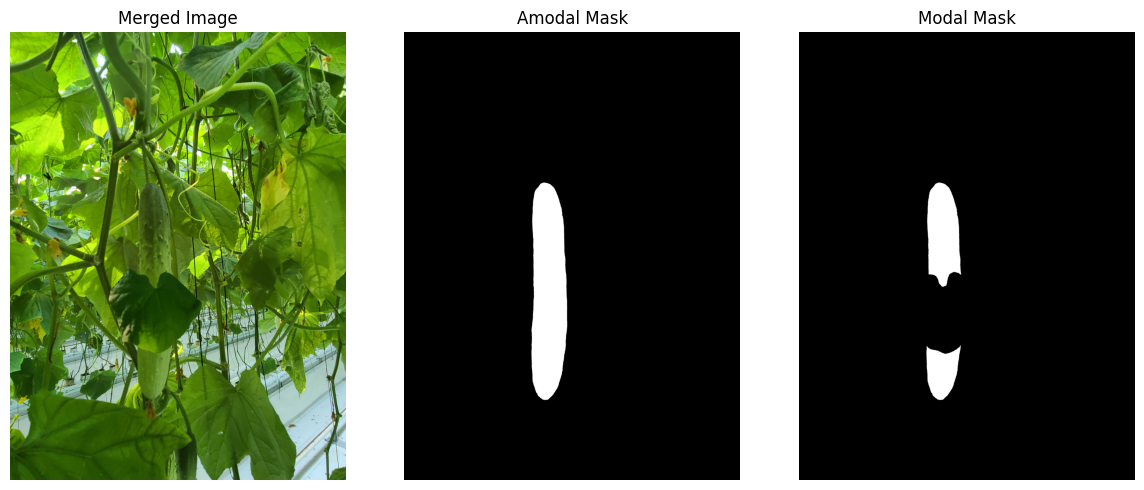

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000001.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000001_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000001_overlap_mask.png
COCO Format 데이터 생성 시작...


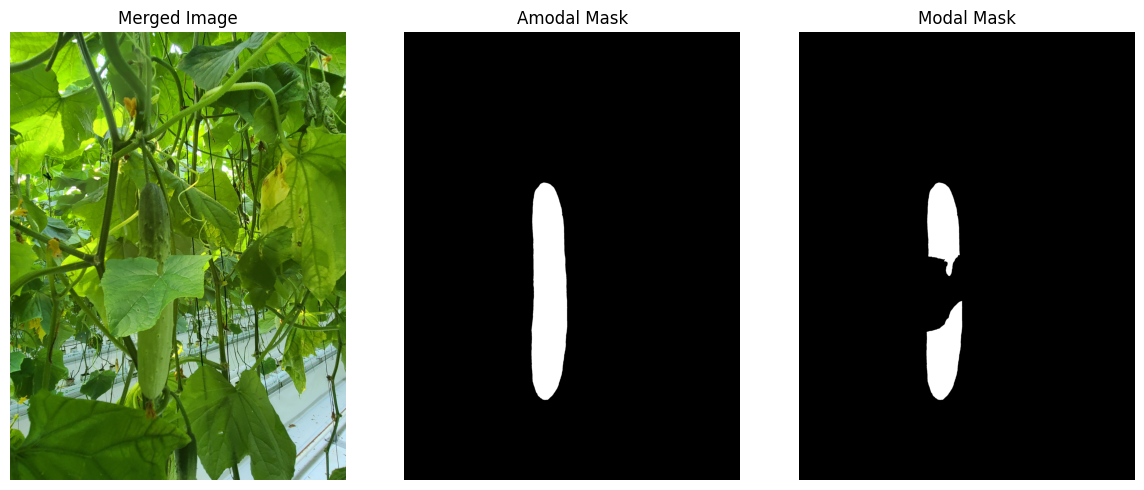

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000002.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000002_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000002_overlap_mask.png
COCO Format 데이터 생성 시작...


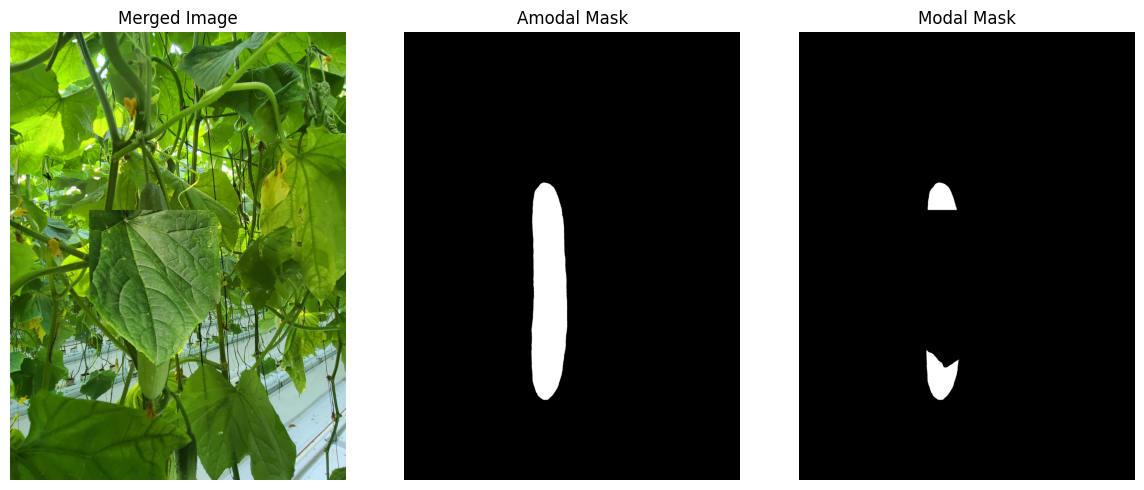

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000003.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000003_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000003_overlap_mask.png
COCO Format 데이터 생성 시작...


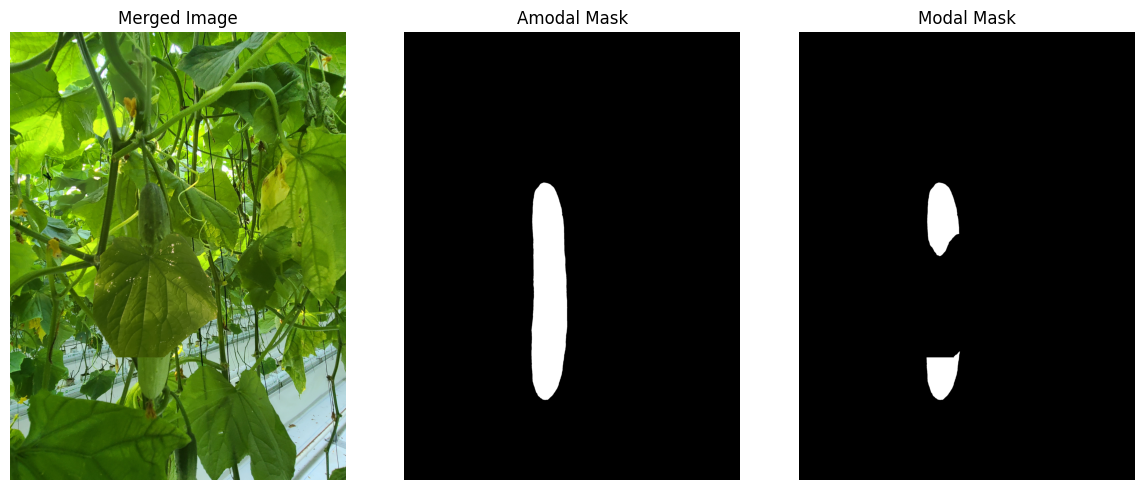

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000004.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000004_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000004_overlap_mask.png
COCO Format 데이터 생성 시작...


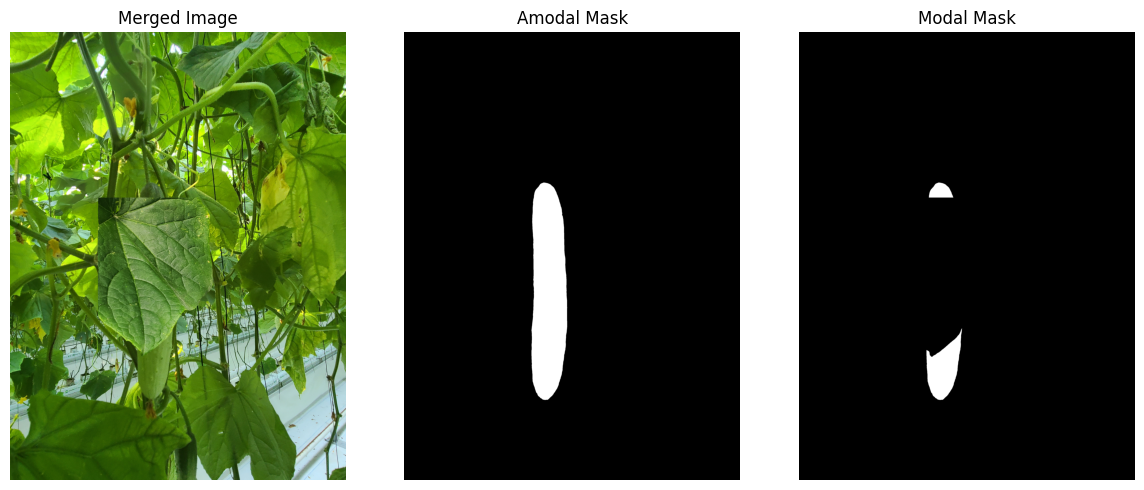

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000005.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000005_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000005_overlap_mask.png
COCO Format 데이터 생성 시작...


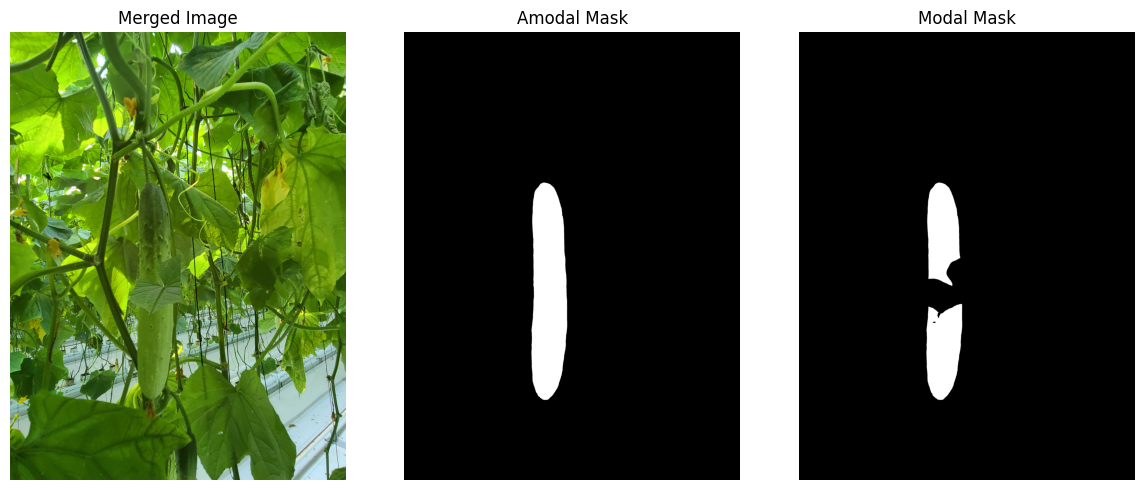

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000006.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000006_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000006_overlap_mask.png
COCO Format 데이터 생성 시작...


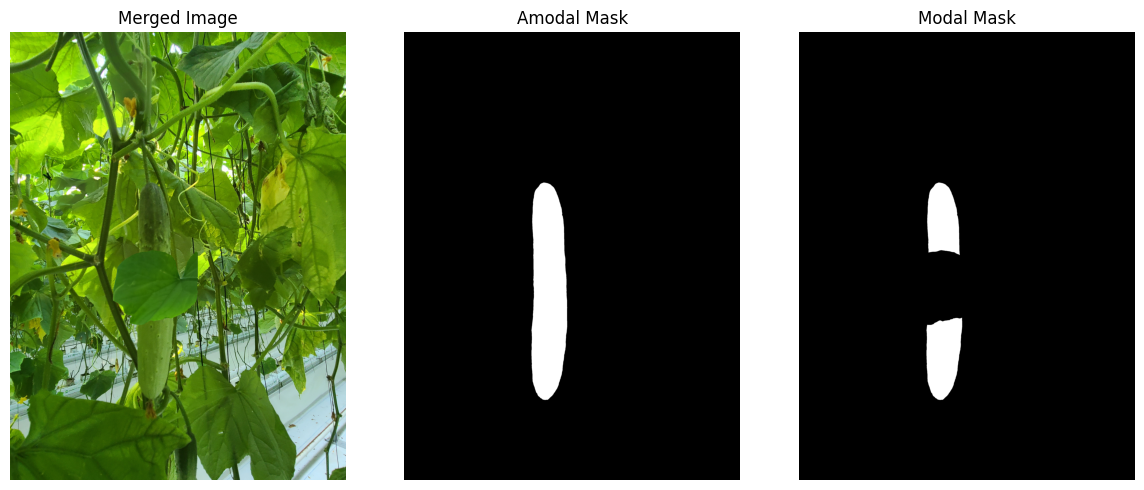

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000007.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000007_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000007_overlap_mask.png
COCO Format 데이터 생성 시작...


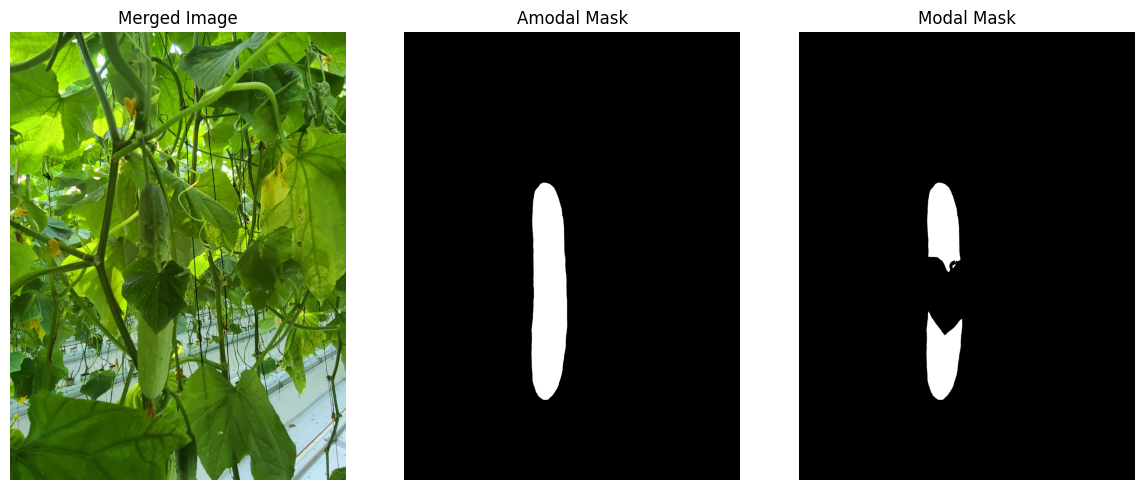

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000008.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000008_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000008_overlap_mask.png
COCO Format 데이터 생성 시작...


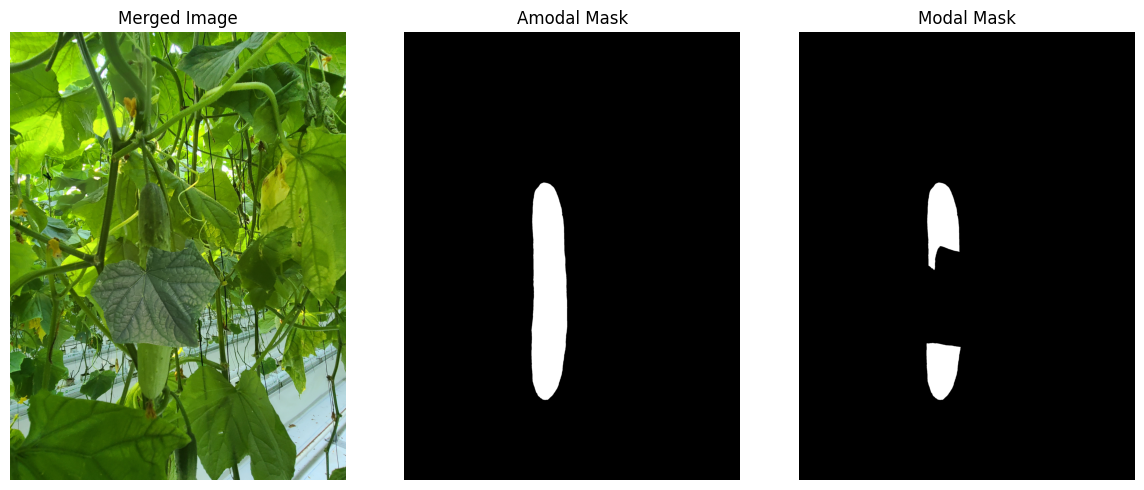

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000009.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000009_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000009_overlap_mask.png
COCO Format 데이터 생성 시작...


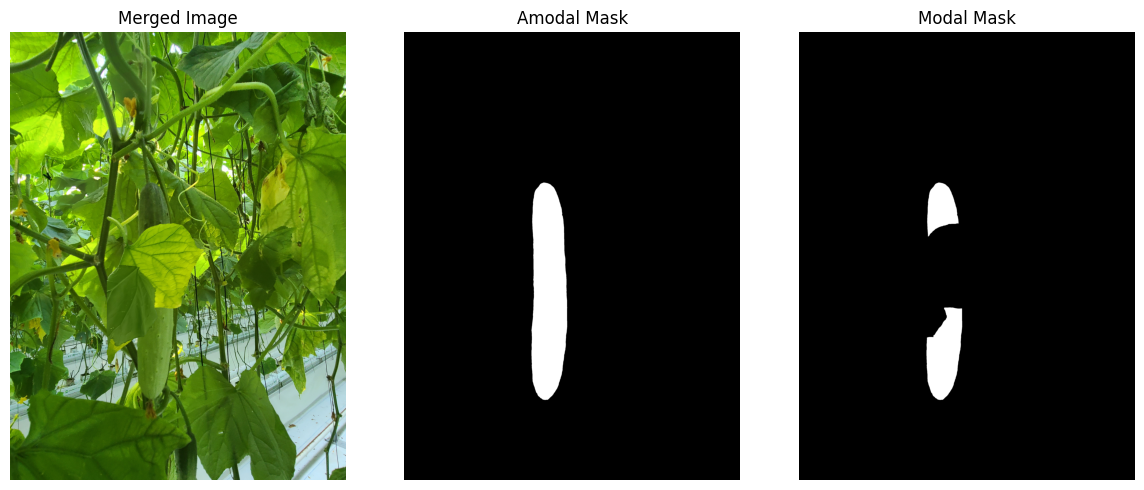

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000010.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000010_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000010_overlap_mask.png
COCO Format 데이터 생성 시작...


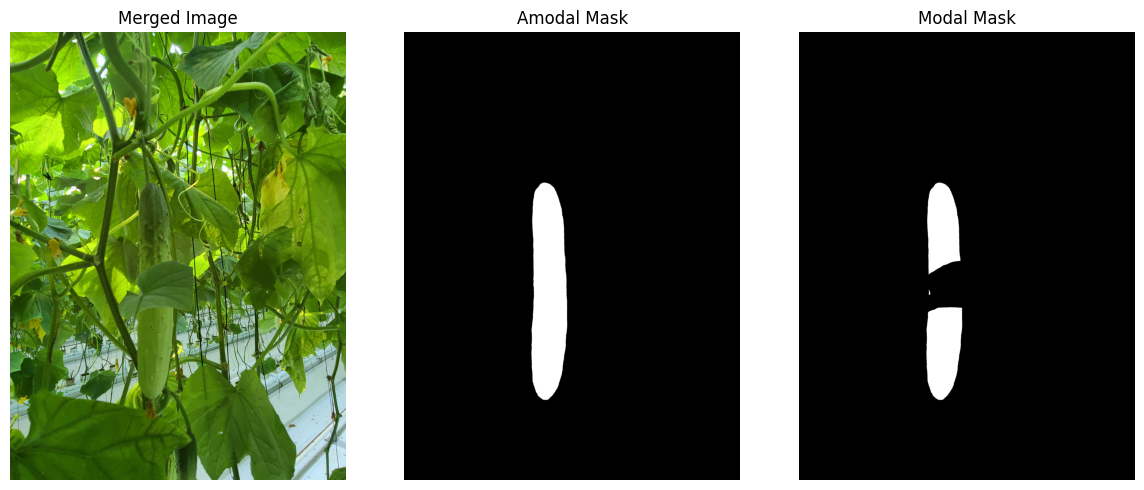

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000011.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000011_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000011_overlap_mask.png
COCO Format 데이터 생성 시작...


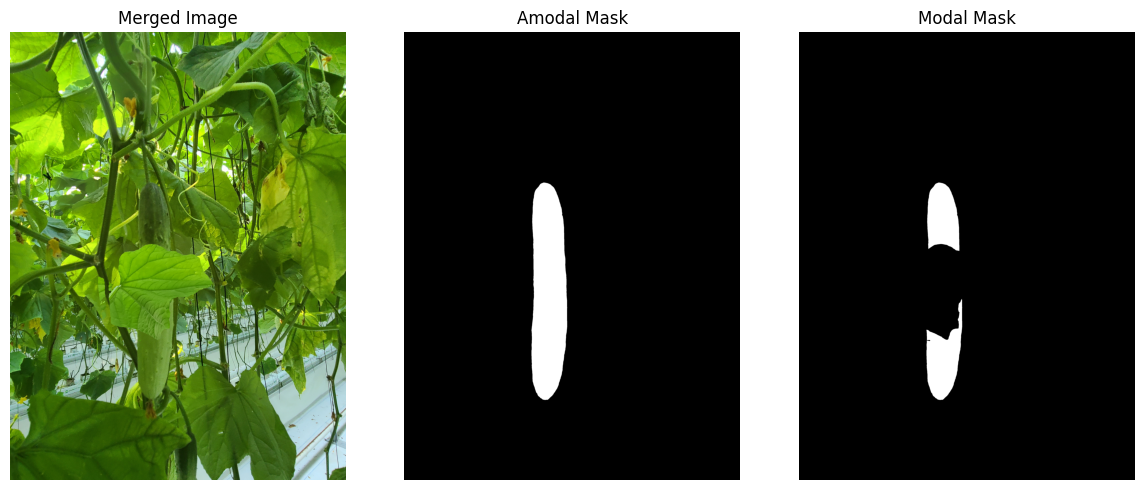

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000012.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000012_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000012_overlap_mask.png
COCO Format 데이터 생성 시작...


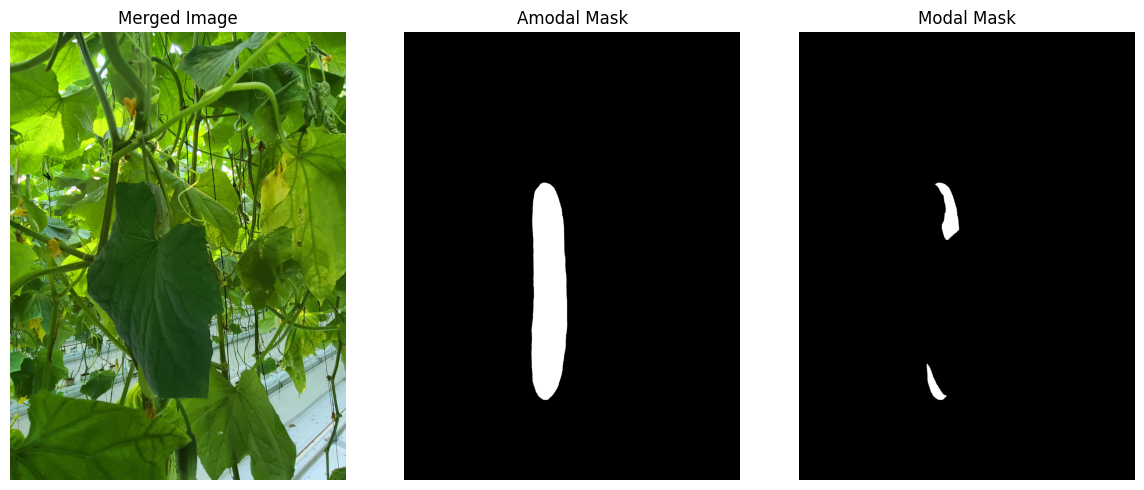

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000013.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000013_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000013_overlap_mask.png
COCO Format 데이터 생성 시작...


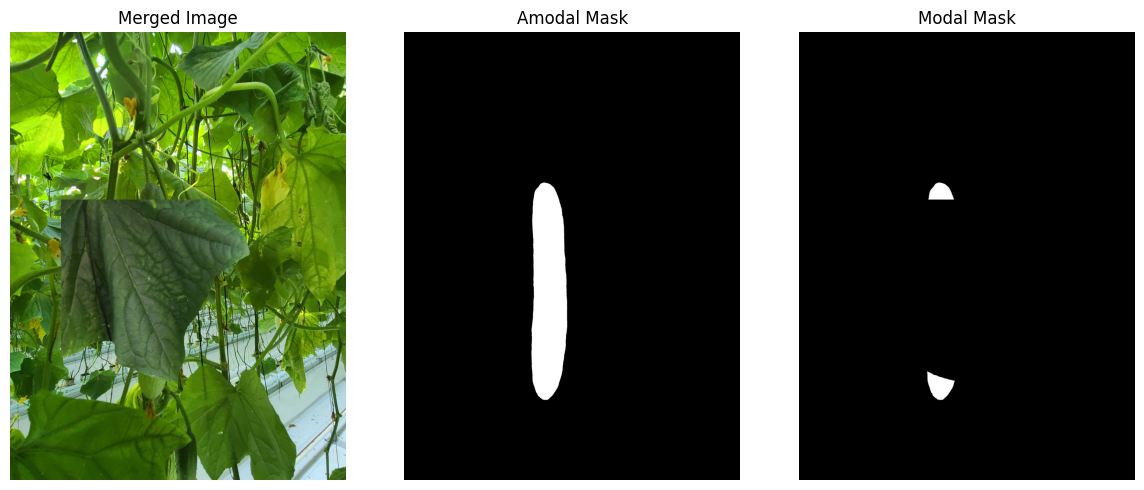

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000014.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000014_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000014_overlap_mask.png
COCO Format 데이터 생성 시작...


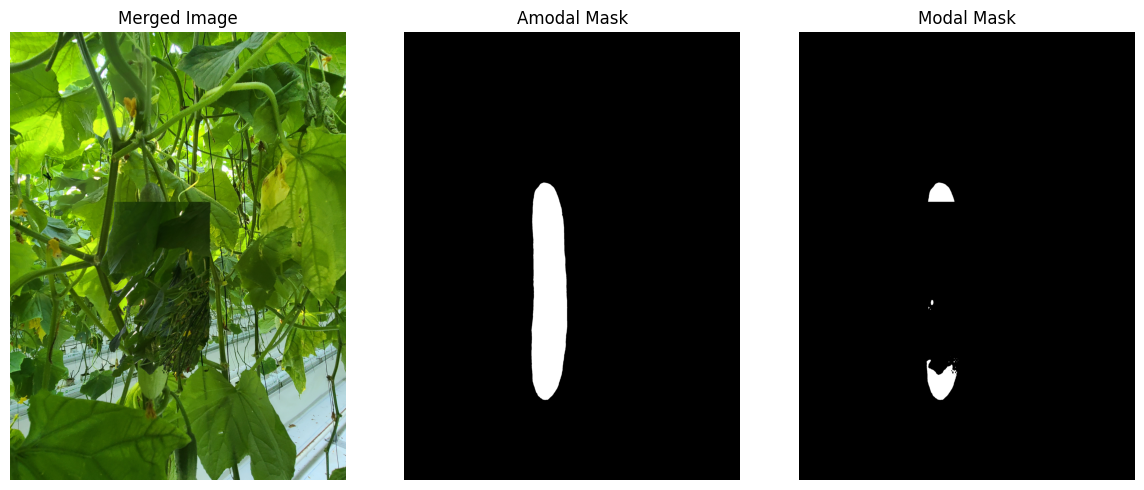

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000015.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000015_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000015_overlap_mask.png
COCO Format 데이터 생성 시작...


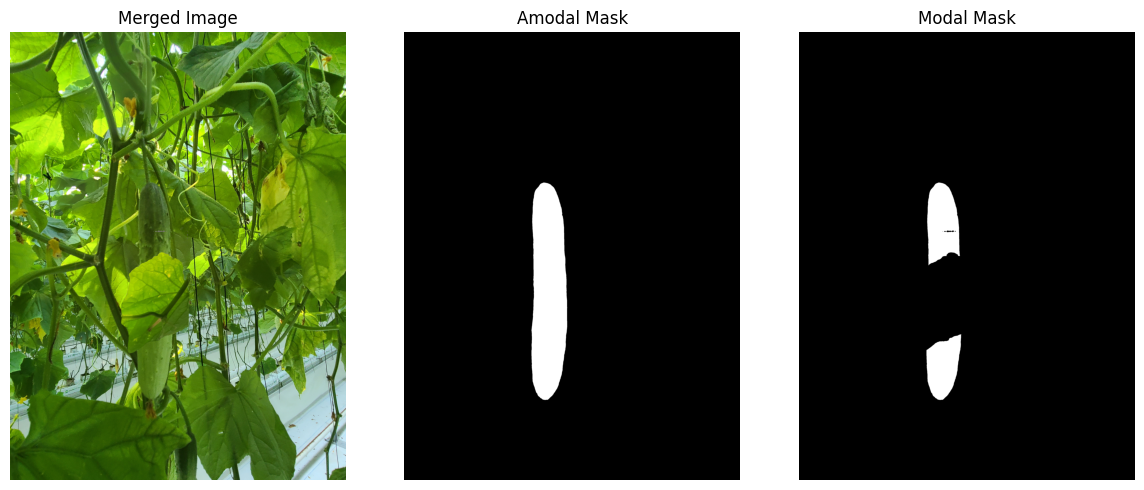

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000016.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000016_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000016_overlap_mask.png
COCO Format 데이터 생성 시작...


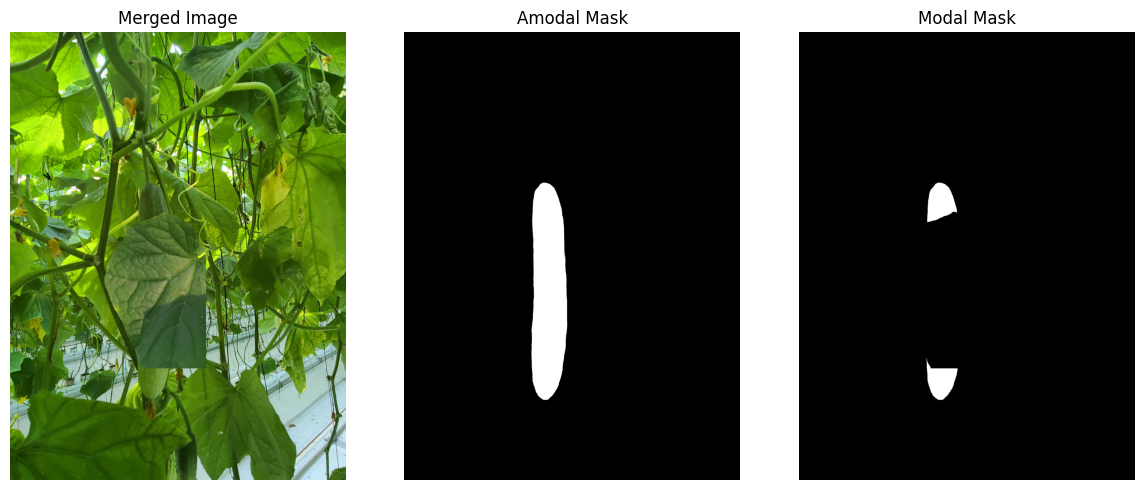

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_140_3_merged_000017.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000017_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_140_3_merged_000017_overlap_mask.png
COCO Format 데이터 생성 시작...


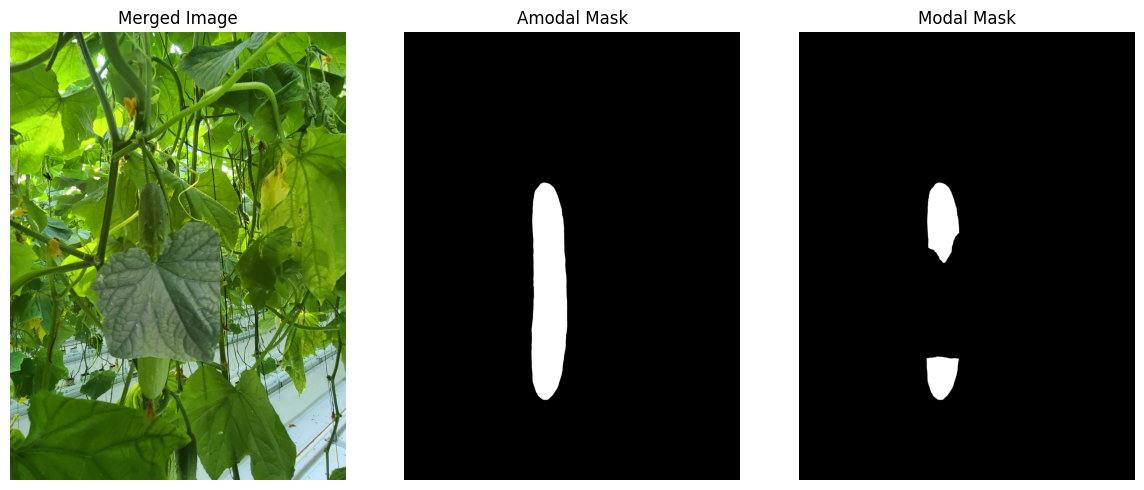

oi_234_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_234_1_merged_000018.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_234_1_merged_000018_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_234_1_merged_000018_overlap_mask.png
COCO Format 데이터 생성 시작...


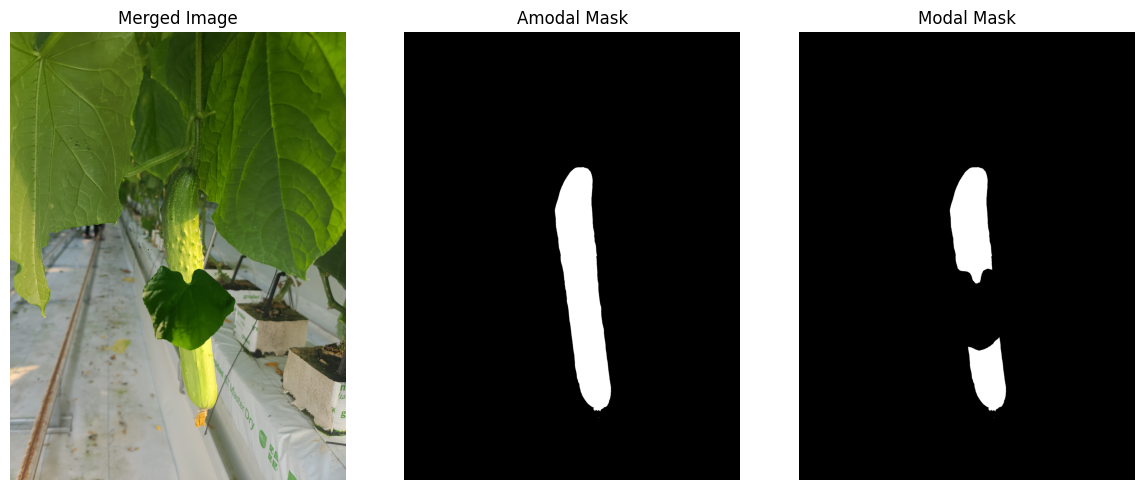

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images3/oi_234_1_merged_000019.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_234_1_merged_000019_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks3/oi_234_1_merged_000019_overlap_mask.png
COCO Format 데이터 생성 시작...


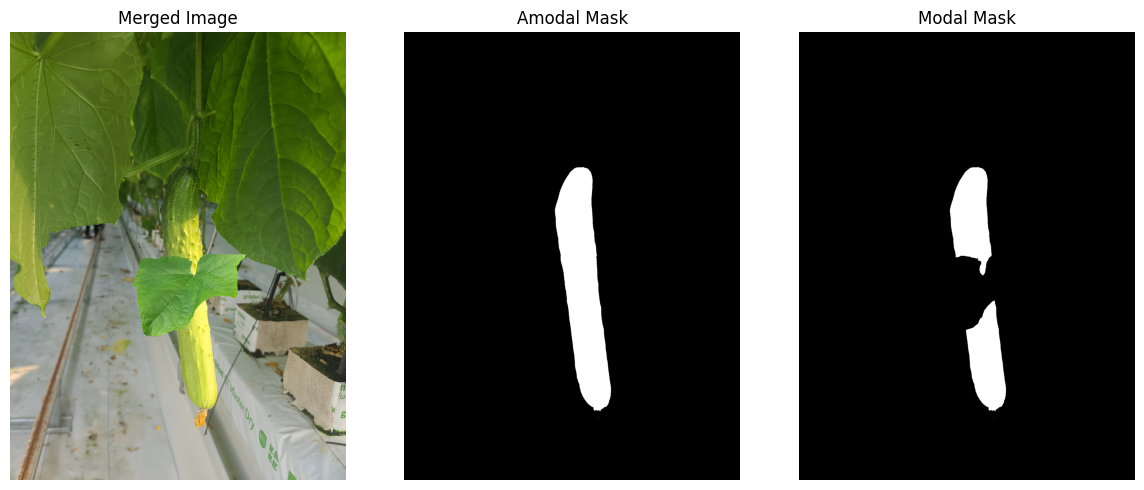

20개의 샘플 생성 완료.
oi_091_2에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_012_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_249_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_148_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_191_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_135_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_245_3에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_115_2에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_242_2에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_058_2에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_241_3에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_090_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_208_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_017_3에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_079_1에 대한 1개의 마스크 확보...
18 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_150_1에 대한 1개의 마스크 확보..

In [5]:
# 특정 클래스 마스크만 선택 (클래스 0: 오이)
def get_cucumber_masks(mask_dir, image_name):
    cucumber_masks = []
    for mask_file in os.listdir(mask_dir):
        # 파일명이 이미지명과 매칭되고 클래스가 0인 마스크만 선택
        if mask_file.startswith(image_name) and '_0_' in mask_file:
            cucumber_masks.append(os.path.join(mask_dir, mask_file))
    return cucumber_masks

# 실행 예시
''' input'''
cucumber_images_dir = INPUT_PATHS["cucumber_images_dir"]
cucumber_masks_dir = INPUT_PATHS["cucumber_masks_dir"]
leaf_cropped_dir = INPUT_PATHS["leaf_cropped_dir"]

''' output dir'''
save_dir = OUTPUT_PATHS["save_dir"]
mask_save_dir = OUTPUT_PATHS["mask_save_dir"]
json_dir = OUTPUT_PATHS["json_dir"]
ensure_directories_exist([save_dir, mask_save_dir, json_dir])

offset_y_range = HYPERPARAMETERS["offset_y_range"]
image_index_start = HYPERPARAMETERS["image_index_start"]

# cucumber 이미지 파일 불러오기
cucumber_image_paths = get_image_paths_from_folder(cucumber_images_dir)

# COCO JSON 초기화
coco_json = initialize_coco_json()

sample_limit = 20  # 생성할 샘플 수
sample_count = 0   # 현재 생성된 샘플 수

global_image_id, global_annotation_id = 0,0
# 각 cucumber 이미지에 대해 마스크와 잎 합성
for cucumber_image_path in cucumber_image_paths:
    # 이미지 이름에서 확장자를 제거하여 기본 이미지명을 가져옴
    image_name = os.path.splitext(os.path.basename(cucumber_image_path))[0]
    
    # 해당 이미지의 오이 마스크들 가져오기 (클래스가 0인 것만)
    cucumber_mask_paths = get_cucumber_masks(cucumber_masks_dir, image_name)

    if len(cucumber_mask_paths) == 0:
        print(f"오이 마스크가 없습니다: {image_name}")
        continue

    # 잎 이미지 경로 선택 (임의의 하나 또는 여러 잎을 사용할 수 있음)
    leaf_cropped_image_paths = get_image_paths_from_folder(leaf_cropped_dir)
    print(f'{image_name}에 대한 {len(cucumber_mask_paths)}개의 마스크 확보...')
    
    # 오이 마스크와 잎 이미지 합성 처리
    for cucumber_mask_path in cucumber_mask_paths:
        print(f'{len(leaf_cropped_image_paths)} 개의 잎 이미지와 합성 시작...')

        for leaf_cropped_image_path in leaf_cropped_image_paths:

            if sample_count >= sample_limit:
                print(f"{sample_limit}개의 샘플 생성 완료.")
                break  # 안쪽 루프 종료

            # offset_y 값을 범위 내에서 무작위로 설정
            offset_y = random.randint(offset_y_range[0], offset_y_range[1])

            # 오이와 잎 이미지를 합성하는 함수 호출
            coco_json,  global_image_id, global_annotation_id = process_amodal_images_and_masks(
                cucumber_image_path=cucumber_image_path,
                leaf_cropped_image_path=leaf_cropped_image_path,
                cucumber_mask_path=cucumber_mask_path,
                save_dir=save_dir,
                mask_save_dir=mask_save_dir,
                coco_json=coco_json,
                global_image_id= global_image_id,
                global_annotation_id= global_annotation_id,
                offset_y=offset_y,
            )
            sample_count += 1  # 샘플 생성 수 증가

        if sample_count >= sample_limit:
            break  # 바깥쪽 루프 종료

# 최종 COCO JSON 저장
output_json_path = os.path.join(json_dir, "dataset.json")
save_coco_json(coco_json, output_json_path)


오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/oi_002_1_merged_30.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks/oi_002_1_merged_30_modal_mask.png
Modal 정보 저장 시작...
JSON 파일 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info/oi_002_1_merged_30_amodal_info.json


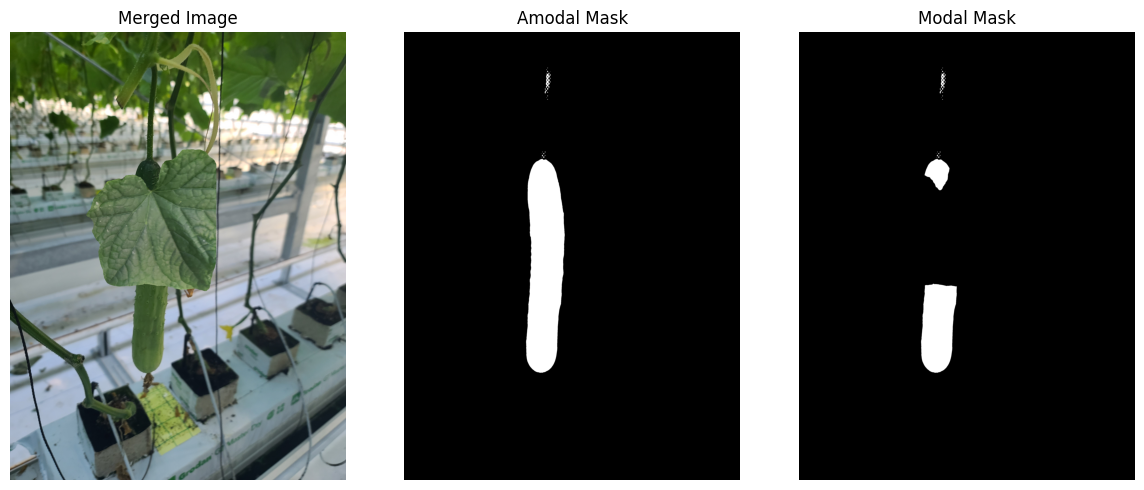

In [17]:
# 실행 예시
''' input'''
cucumber_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/images/oi_002_1.jpg"
leaf_cropped_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_029_3_1_00.png"
cucumber_mask_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/masks/oi_002_1_0_00.png"


''' output dir'''
save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images"
mask_save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks"
json_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info"
offset_y = 30
image_index = 0
#
process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, save_dir, mask_save_dir, json_dir, image_index, offset_y)

In [13]:
import os
import shutil

# 특정 클래스(잎 클래스 1) 이미지를 선택하여 다른 폴더로 복사
def copy_leaves_images(cropped_objects_dir, target_dir, class_id="1"):
    # 타겟 디렉토리가 없으면 생성
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # cropped_objects 폴더 내 파일들 탐색
    for file_name in os.listdir(cropped_objects_dir):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            # 파일명에서 클래스 정보를 추출 (예: cropped_oi_001_1_xx.png)
            parts = file_name.split('_')
            if len(parts) > 4 and parts[4] == class_id:  # 클래스가 4번째 위치에 있는지 확인
                source_file = os.path.join(cropped_objects_dir, file_name)
                target_file = os.path.join(target_dir, file_name)
                
                # 파일 복사
                shutil.copy2(source_file, target_file)
                print(f"복사 완료: {source_file} -> {target_file}")

# 경로 설정
cropped_objects_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects"
selected_cropped_leaves_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves"

# 잎 클래스(1) 이미지만 선택하여 복사
copy_leaves_images(cropped_objects_dir, selected_cropped_leaves_dir, class_id="1")


복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_054_2_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_054_2_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_139_3_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_139_3_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_221_3_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_221_3_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_100_2_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_100_2_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_008_3_1_01.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_lea